#Introduction

---

**Goal** : Predict behavior to retain customers

##Dataset Information

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month 

* the column is called Churn
Services that each customer has signed up for 

* phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information 

* how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers 

* gender, age range, and if they have partners and dependents

In [ ]:
!pip install feature-engine
import warnings 
warnings.filterwarnings('ignore')

     |████████████████████████████████| 205 kB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 34.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2

#Data Loading

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/hanarifdahs/datasets/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


#Data Cleaning

##Change Data Type

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

##Check missing value

In [ ]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

##Handle duplicate data

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.drop_duplicates(inplace=True)

#EDA

**What is the precentage of each values in the target variable?**

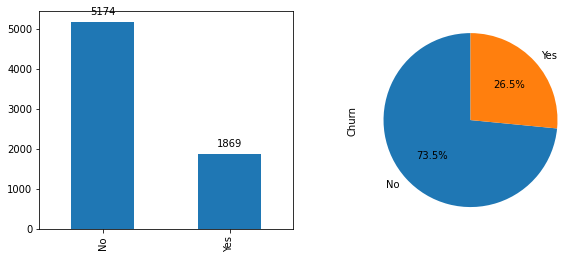

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
figs = df['Churn'].value_counts().plot(kind='bar', ax=axs[0])
for p in figs.patches:
  figs.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width()/2., p.get_height()),ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', startangle = 90, ax=axs[1])

There were about 26.5% of customers who changed to another provider

The target variable seems quite imbalance, we will consider it while processing the data

**Categorical variables comparison based on churn**

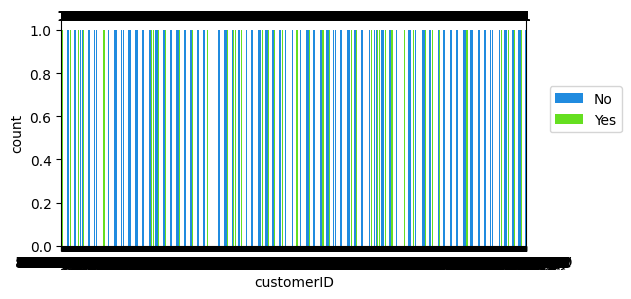

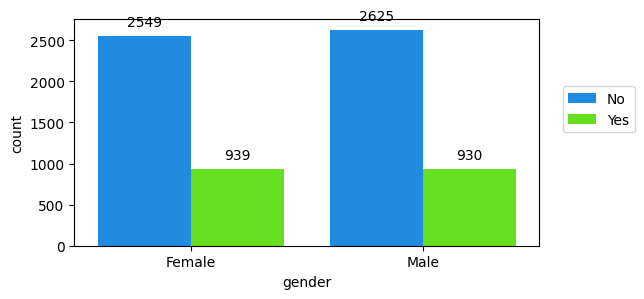

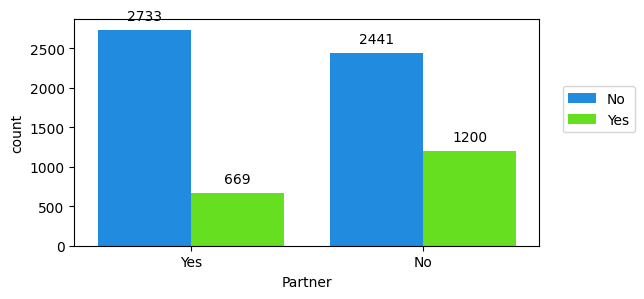

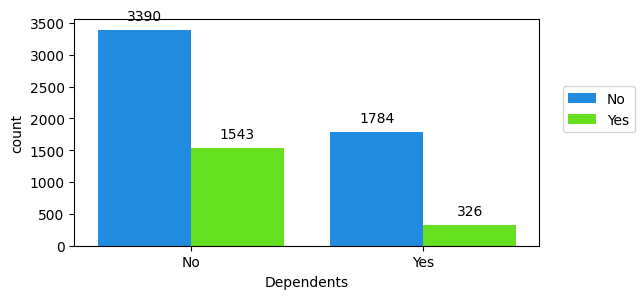

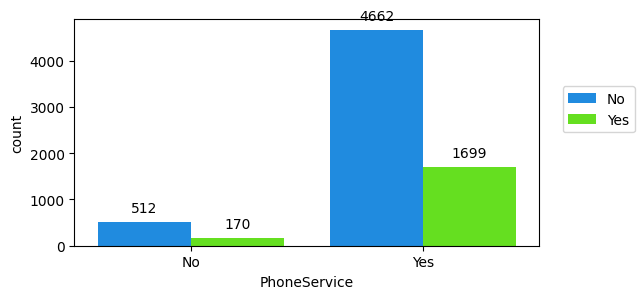

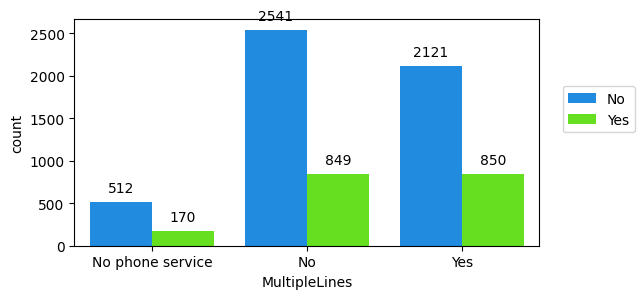

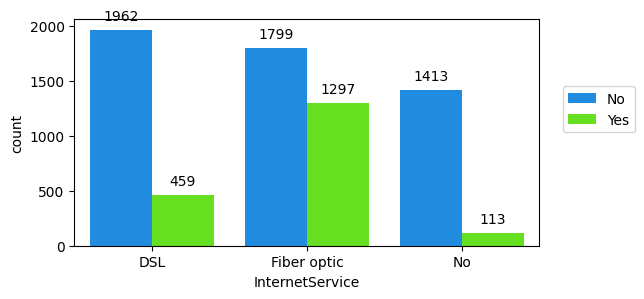

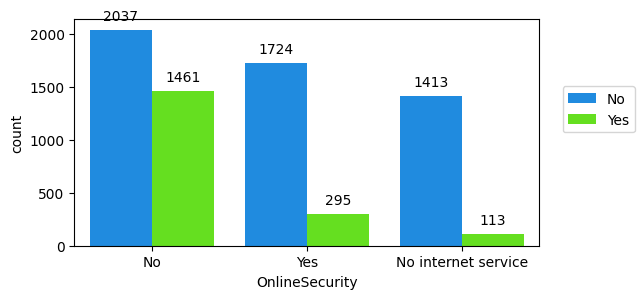

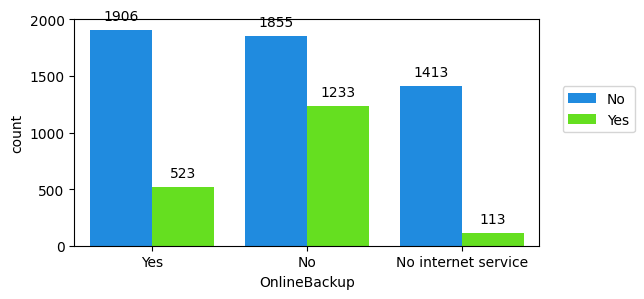

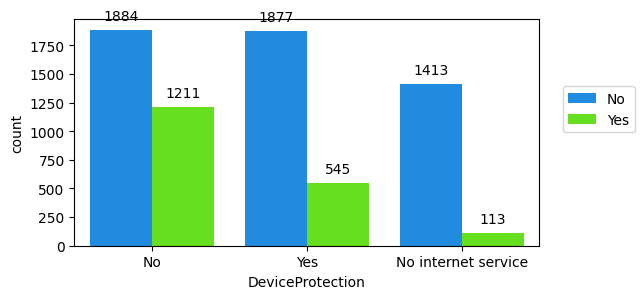

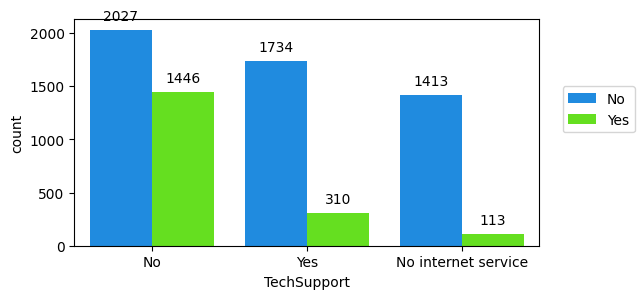

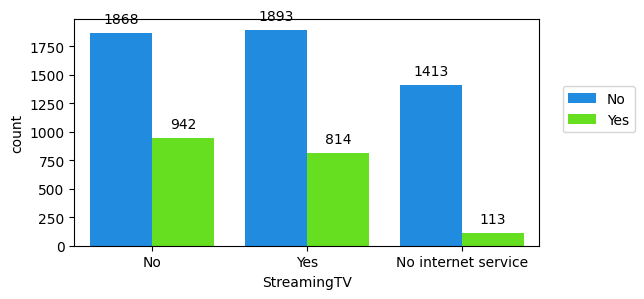

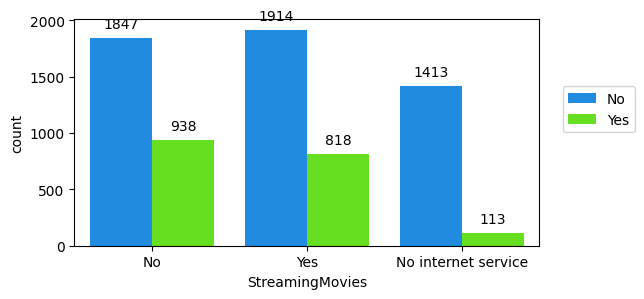

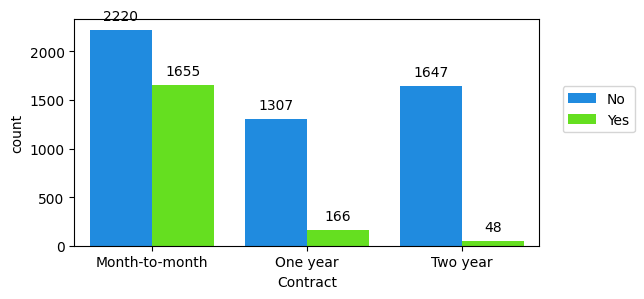

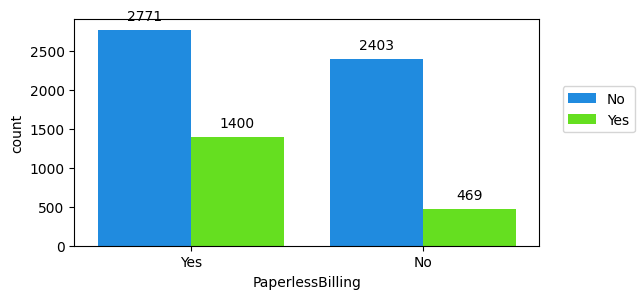

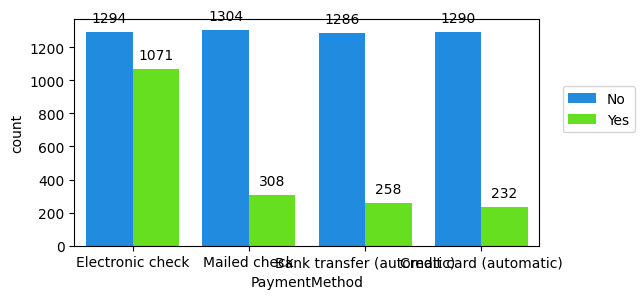

In [ ]:
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']

for col in cat_features[:-1]:
    plt.figure(figsize=(6,3), dpi=100)
    fig = sns.countplot(data=df,x=col,hue ='Churn',palette='gist_rainbow_r')
    for p in fig.patches:
      fig.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width()/2., p.get_height()),ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    plt.legend(loc=(1.05,0.5))

From the categorical variables based on churn, we get that

* We will definitely drop customer ID

* There is no significant difference who changed the service provider based on the gender. We'll likely to drop it

* Customer that does't have a partner more likely churn

* Customer that doesn't have dependents are likely churn

* Customer that have phone service likely churn

* Customer that do and doesn't have multiple lines likely churn, it seems like it doesn't affect on the target variable

* Customer with fiber optic internet service likely churn, this could affect on the target variable

* Customer that doesn't have device protection likely to churn, this could also affect on the target variable

* Online backup, online security, tech support, streaming TV, streaming movies, paperless billing, and payment method could not affect the target variable, but we should take a look for a further research on it

* Contract with month to month contract is highly churn, we will consider it as one of the future

**Correlation between numeric variables**

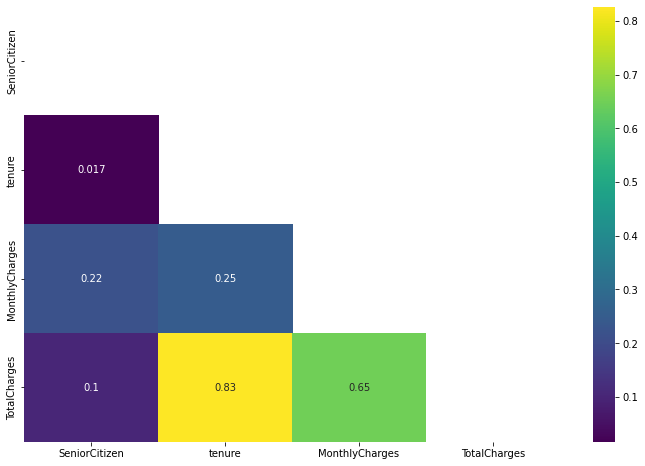

In [ ]:
plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), annot = True, cmap='viridis', mask=mask)

There is no high correlation between the numeric features

#Data Preprocessing

##Drop Unused Columns

In [ ]:
df.drop('customerID', axis = 1,inplace = True)

##Cardinality

In [ ]:
obj_col = df.select_dtypes(include=['object'])
for cat in obj_col:
  count = len(df[cat].unique())
  print(f"Cardinality of column {cat} is {count}")

Cardinality of column gender is 2
Cardinality of column Partner is 2
Cardinality of column Dependents is 2
Cardinality of column PhoneService is 2
Cardinality of column MultipleLines is 3
Cardinality of column InternetService is 3
Cardinality of column OnlineSecurity is 3
Cardinality of column OnlineBackup is 3
Cardinality of column DeviceProtection is 3
Cardinality of column TechSupport is 3
Cardinality of column StreamingTV is 3
Cardinality of column StreamingMovies is 3
Cardinality of column Contract is 3
Cardinality of column PaperlessBilling is 2
Cardinality of column PaymentMethod is 4
Cardinality of column Churn is 2


##Split Data

In [ ]:
X = df.drop('Churn', axis = 1)
y = df.Churn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, stratify=y_train)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((5017, 19), (1761, 19), (265, 19))

In [ ]:
y_train

5534     No
608      No
5930     No
5743     No
3654     No
       ... 
6643     No
1306    Yes
158      No
2176     No
4550     No
Name: Churn, Length: 5017, dtype: object

##Handling Missing Values


Check missing values

In [ ]:
X_train.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        8
dtype: int64

In [ ]:
X_test.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
dtype: int64

In [ ]:
X_val.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Missing values occured in X_train and X_test, since it is only occured a little on the dataset we'll likely to drop it

In [ ]:
train_to_drop = X_train[X_train['TotalCharges'].isnull()].index.tolist()

In [ ]:
test_to_drop = X_test[X_test['TotalCharges'].isnull()].index.tolist()

In [ ]:
y_train.drop(train_to_drop, inplace = True)

In [ ]:
y_test.drop(test_to_drop, inplace = True)

In [ ]:
X_train.dropna(inplace=True)

In [ ]:
X_test.dropna(inplace=True)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5009, 19), (1758, 19), (5009,), (1758,))

##Handling Outliers

Check Outliers

In [ ]:
num_train = X_train._get_numeric_data()
for k, v in num_train.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_train)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column SeniorCitizen outliers = 100.00%
Column tenure outliers = 0.00%
Column MonthlyCharges outliers = 0.00%
Column TotalCharges outliers = 0.00%


In [ ]:
num_test = X_test._get_numeric_data()
for k, v in num_test.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_test)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column SeniorCitizen outliers = 100.00%
Column tenure outliers = 0.00%
Column MonthlyCharges outliers = 0.00%
Column TotalCharges outliers = 0.46%


In [ ]:
num_val = X_val._get_numeric_data()
for k, v in num_val.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_val)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column SeniorCitizen outliers = 100.00%
Column tenure outliers = 0.00%
Column MonthlyCharges outliers = 0.00%
Column TotalCharges outliers = 0.00%


Handle outliers in test set with capping

In [ ]:
windsoriser = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['TotalCharges'])

windsoriser.fit(X_test)

X_test = windsoriser.transform(X_test)

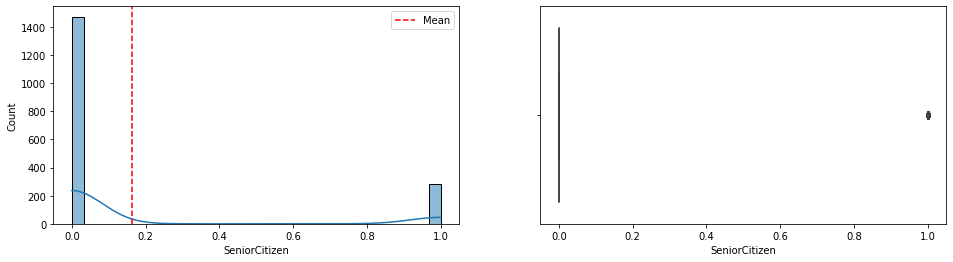

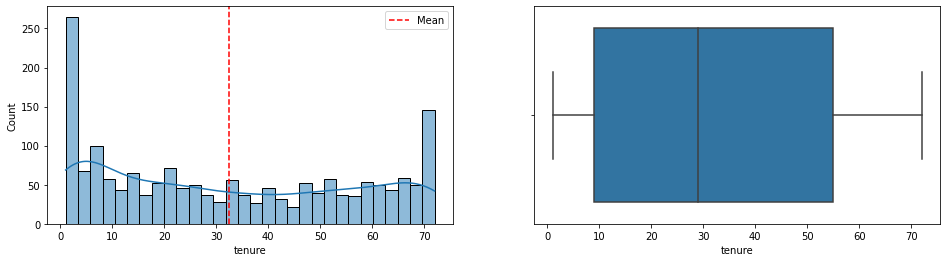

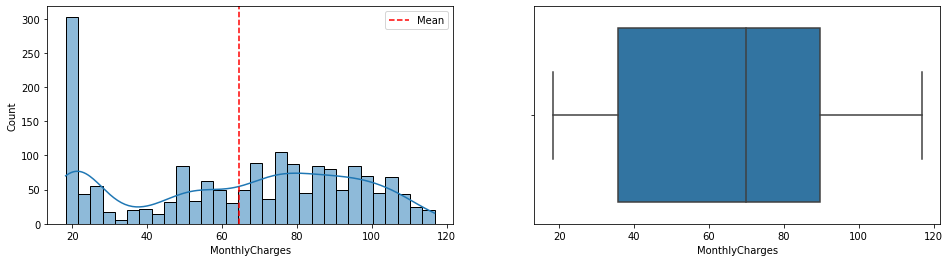

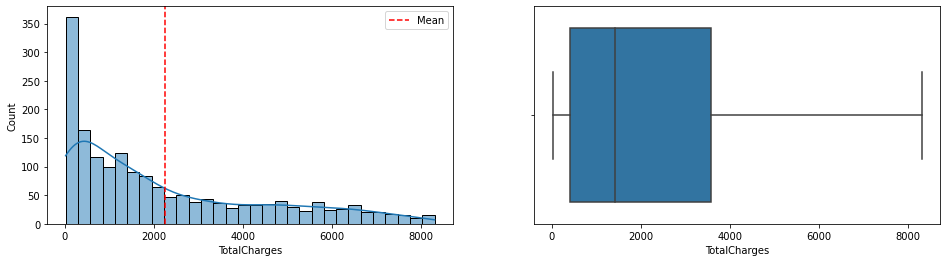

In [ ]:
num_test = X_test._get_numeric_data()
for i in num_test:
  fig, axs = plt.subplots(1,2,figsize=(16, 4))
  sns.histplot(num_test[i], bins = 30, kde=True, ax = axs[0])
  sns.boxplot(num_test[i], ax = axs[1])

  axs[0].axvline(num_test[i].mean(), color='red', linestyle='dashed', label = 'Mean')
  axs[0].legend()

##Feature Selection

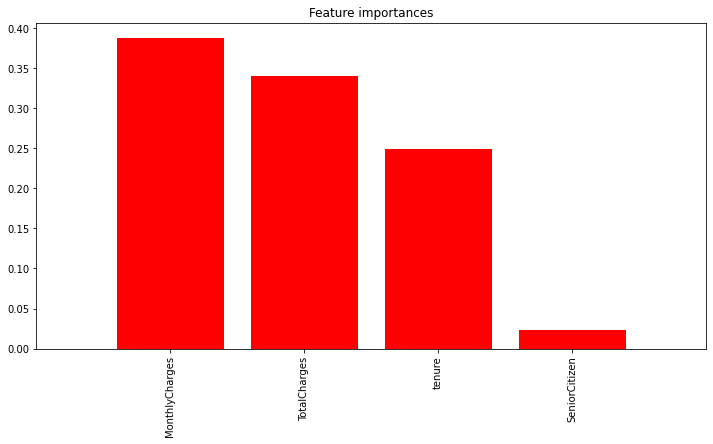

In [ ]:
X_train_num = X_train._get_numeric_data()
# feature extraction
model = ExtraTreesClassifier(n_estimators=400)
model.fit(X_train_num, y_train)

# feature_importances_ dari highest ke lowest
sorted_idx = np.argsort(model.feature_importances_)
sorted_idx = sorted_idx[::-1]

# plot feature importances
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X_train_num.shape[1]), model.feature_importances_[sorted_idx],
        color="r", align="center")
plt.xticks(range(X_train_num.shape[1]), X_train_num.columns[sorted_idx], rotation=90)
plt.xlim([-1, X_train_num.shape[1]])
plt.show()

From the feature importance and EDA, we get that 

Total charges, tenure, Monthly charges, and contract are impactful to the target. So we will use these variables as our features

In [ ]:
X_train = X_train.loc[:,['TotalCharges', 'tenure', 'MonthlyCharges','Contract','InternetService', 'DeviceProtection']]
X_test = X_test.loc[:,['TotalCharges', 'tenure', 'MonthlyCharges','Contract','InternetService', 'DeviceProtection']]
X_val = X_val.loc[:,['TotalCharges', 'tenure', 'MonthlyCharges','Contract','InternetService', 'DeviceProtection']]

In [ ]:
X_train

,TotalCharges,tenure,MonthlyCharges,Contract,InternetService,DeviceProtection
5534,1747.20,21,80.35,Month-to-month,Fiber optic,No
608,8306.05,72,114.55,Two year,Fiber optic,Yes
5930,6185.15,72,84.70,Two year,Fiber optic,No
5743,735.90,38,20.20,Two year,No,No internet service
3654,2433.50,28,89.90,Month-to-month,Fiber optic,Yes
...,...,...,...,...,...,...
6643,239.05,3,74.60,Month-to-month,Fiber optic,No
1306,8127.60,70,115.55,One year,Fiber optic,Yes
158,1024.00,16,64.25,Two year,DSL,Yes
2176,1284.20,67,19.40,Two year,No,No internet service


##Feature Encoding

Encode with one hot encoding to the categorical variables

In [ ]:
cat = ['Contract','InternetService','DeviceProtection']
X_train = pd.get_dummies(X_train, prefix='', prefix_sep='', 
                            columns=cat)
X_test = pd.get_dummies(X_test, prefix='', prefix_sep='', 
                            columns=cat)
X_val = pd.get_dummies(X_val, prefix='', prefix_sep='', 
                            columns=cat)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((5009, 12), (1758, 12), (265, 12))

Encode target variable

In [ ]:
cleanup_nums = {
    'Yes' : 1,
    'No' : 0 
}

y_train = y_train.replace(cleanup_nums)
y_test = y_test.replace(cleanup_nums)
y_val = y_val.replace(cleanup_nums)

In [ ]:
y_train

5534    0
608     0
5930    0
5743    0
3654    0
       ..
6643    0
1306    1
158     0
2176    0
4550    0
Name: Churn, Length: 5009, dtype: int64

##Handle Imbalance Data

Turn the data to tensor and normalize the train data to use SMOTE

In [ ]:
X_train = tf.convert_to_tensor(X_train)
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(X_train)
X_train = normalizer(X_train)

Change the X_train data into numpy

In [ ]:
X_train = X_train.numpy()

Use SMOTE

In [ ]:
# Minority Class will have same the same number as the majority class
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
y_train_resampled.value_counts()

1    3677
0    3677
Name: Churn, dtype: int64

In [ ]:
X_train_resampled.shape

(7354, 12)

In [ ]:
y_train_resampled.shape

(7354,)

#Modelling

We use pipeline to shuffle and create the data with a separate element for each row of the input tensor

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train_resampled, y_train_resampled)).shuffle(100).batch(100)
test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(100).batch(100)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(100).batch(100)

We use sequential API to build the base model, we try to make 2 hidden layers using relu activation function for input layer and hidden layer, sigmoid activation function for the output layer. In input layer we use 12 features as the input

In [ ]:
model = Sequential()
model.add(Dense(12,activation='relu', input_shape=(12,)))
model.add(normalizer)
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 normalization (Normalizatio  (None, 12)               25        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 8)                 104       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 326
Trainable params: 301
Non-trainable params: 25
_______________________________________________________

For the optimzer we use adam and binary crossentropy for the loss function. The metrics that we use accuracy. Then we fit the model with 50 epochs

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'] )

# history = model.fit(X_train_resampled, y_train_resampled, epochs = 30, validation_data=(X_val, y_val))
history = model.fit(train, epochs = 50, validation_data = val)

Epoch 1/50
74/74 [==============================] - 3s 9ms/step - loss: 0.6231 - accuracy: 0.6874 - val_loss: 81.2321 - val_accuracy: 0.2642
Epoch 2/50
74/74 [==============================] - 0s 6ms/step - loss: 0.5783 - accuracy: 0.7223 - val_loss: 64.8433 - val_accuracy: 0.2642
Epoch 3/50
74/74 [==============================] - 0s 6ms/step - loss: 0.5613 - accuracy: 0.7380 - val_loss: 59.8031 - val_accuracy: 0.2642
Epoch 4/50
74/74 [==============================] - 0s 5ms/step - loss: 0.5516 - accuracy: 0.7423 - val_loss: 54.6427 - val_accuracy: 0.2642
Epoch 5/50
74/74 [==============================] - 0s 7ms/step - loss: 0.5455 - accuracy: 0.7419 - val_loss: 52.2911 - val_accuracy: 0.2642
Epoch 6/50
74/74 [==============================] - 0s 5ms/step - loss: 0.5415 - accuracy: 0.7430 - val_loss: 49.6987 - val_accuracy: 0.2642
Epoch 7/50
74/74 [==============================] - 0s 5ms/step - loss: 0.5389 - accuracy: 0.7430 - val_loss: 54.2807 - val_accuracy: 0.2642
Epoch 8/50
74

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['loss']

[0.6231100559234619,
 0.5782839059829712,
 0.561267077922821,
 0.5516254901885986,
 0.5455012321472168,
 0.5414580702781677,
 0.5389139652252197,
 0.5374785661697388,
 0.5357381701469421,
 0.5346823334693909,
 0.5331961512565613,
 0.5319163799285889,
 0.5308963656425476,
 0.5300184488296509,
 0.5290403366088867,
 0.5282953381538391,
 0.5280106663703918,
 0.5272600054740906,
 0.5268663763999939,
 0.5261258482933044,
 0.5258270502090454,
 0.5256078243255615,
 0.5253487229347229,
 0.5248317122459412,
 0.5243687033653259,
 0.5237330198287964,
 0.5230510234832764,
 0.5223946571350098,
 0.5224553346633911,
 0.5218088030815125,
 0.5217459201812744,
 0.5214298367500305,
 0.5210564732551575,
 0.5207453370094299,
 0.5207595825195312,
 0.5202206373214722,
 0.5199719071388245,
 0.520329475402832,
 0.5205077528953552,
 0.5190807580947876,
 0.5191881656646729,
 0.5188271403312683,
 0.5186089873313904,
 0.5184605121612549,
 0.5180817246437073,
 0.517761766910553,
 0.5178776979446411,
 0.5176488757133

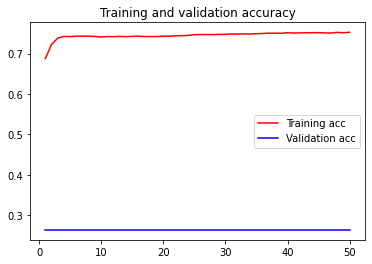

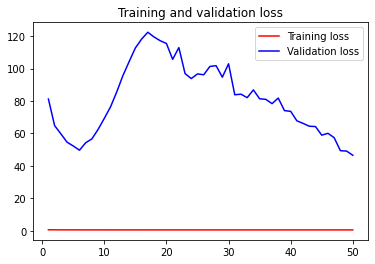

In [ ]:
# Visualize accuracy and loss for train and validation data

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

In the accuracy result on the base model, the result is a little bit over-fit. 

For the loss result, it is obviously under-fit because the validation loss is pretty much higher than the training loss, this could be because we haven't try any effort to optimize the model like dropout, regularization, and etc.

#Model Optimization

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train_resampled, y_train_resampled)).shuffle(100).batch(150)
test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(100).batch(150)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(100).batch(150)

In this model optimazation, we use sequential API to train the model, we still use 2 hidden layers cause the input layer is not really that much. We still also use all of the activation function in the base model. AFter we normalize the input we use dropout and batch normalization in each layers and also we use regularizer in each hidden layers.

In [ ]:
model = Sequential()
model.add(Dense(12,activation='relu', input_shape=(12,)))
model.add(normalizer)
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(4, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 12)                156       
                                                                 
 normalization (Normalizatio  (None, 12)               25        
 n)                                                              
                                                                 
 dropout_35 (Dropout)        (None, 12)                0         
                                                                 
 batch_normalization_35 (Bat  (None, 12)               48        
 chNormalization)                                                
                                                                 
 dense_52 (Dense)            (None, 8)                 104       
                                                                 
 dropout_36 (Dropout)        (None, 8)               

In the optimizer we set the learning rate by 0.01, the other parameters are still the same with the base model.

We try the epoch with 100 iteration

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.1)
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.1, momentum=0.0, clipnorm=1.0, nesterov=False, name="SGD"
)
model.compile(loss = 'binary_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

# model.compile(optimizer='adamax', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                 metrics=['accuracy'] )

# history = model.fit(X_train_resampled, y_train_resampled, epochs = 30, validation_data=(X_val, y_val))
history = model.fit(train, epochs = 100, validation_data = val)

Epoch 1/100
50/50 [==============================] - 5s 17ms/step - loss: 1.7328 - accuracy: 0.5917 - val_loss: 1.8301 - val_accuracy: 0.7245
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 0.8119 - accuracy: 0.5801 - val_loss: 0.7898 - val_accuracy: 0.4453
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 0.6862 - accuracy: 0.6410 - val_loss: 0.9303 - val_accuracy: 0.2642
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 0.6683 - accuracy: 0.6527 - val_loss: 0.7254 - val_accuracy: 0.5057
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 0.6709 - accuracy: 0.6507 - val_loss: 0.8256 - val_accuracy: 0.3434
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 0.6682 - accuracy: 0.6581 - val_loss: 0.8786 - val_accuracy: 0.2642
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: 0.6618 - accuracy: 0.6499 - val_loss: 0.9468 - val_accuracy: 0.2642
Epoch 8/100


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['loss']

[1.7327791452407837,
 0.8119098544120789,
 0.6861693859100342,
 0.6683160066604614,
 0.6709166765213013,
 0.6682025790214539,
 0.6617695093154907,
 0.6685032844543457,
 0.6640009880065918,
 0.6668103933334351,
 0.6729699373245239,
 0.6647411584854126,
 0.6664044857025146,
 0.664609968662262,
 0.6640472412109375,
 0.6638241410255432,
 0.6688245534896851,
 0.6622700095176697,
 0.6638753414154053,
 0.6660266518592834,
 0.6573025584220886,
 0.6614587306976318,
 0.6624158024787903,
 0.6556462645530701,
 0.6611027121543884,
 0.6622620820999146,
 0.6569915413856506,
 0.6591385006904602,
 0.65961092710495,
 0.654067873954773,
 0.6599331498146057,
 0.6657239198684692,
 0.6959638595581055,
 0.6939660310745239,
 0.6938934326171875,
 0.694068968296051,
 0.6941682696342468,
 0.6942384839057922,
 0.6943840384483337,
 0.6944787502288818,
 0.6944926977157593,
 0.6946994662284851,
 0.6946783065795898,
 0.6948668360710144,
 0.6948359608650208,
 0.6949292421340942,
 0.6949821710586548,
 0.695045292377471

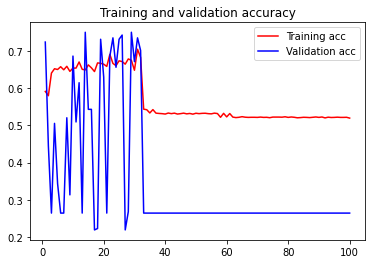

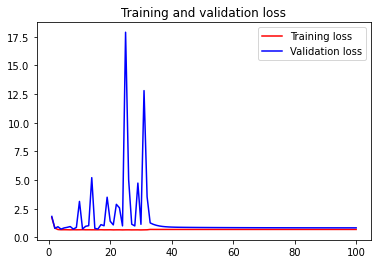

In [ ]:
# Visualize accuracy and loss for train and validation data

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

These are the result of the model after doing some optimization, These are the best result that I got, I honestly don't know why this could happend, I've tried to change all of the parameters and also change the activation function but it doesn't make the result convergent. The model clearly not stable with a new data. My indication on this case is on the features that I used or the parameters that is not fit enough to find the optimum score.

#Save Model

In [ ]:
model.save("model.h5")

#Model Prediction

In [ ]:
res = model.predict(X_val)
res

array([[0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],
       [0.6177279],


In [ ]:
##bikin threshold
thres = 0.5
res = (res > thres).T
res

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [ ]:
res = res.astype(int)[0]
res

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, res))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       195
           1       0.26      1.00      0.42        70

    accuracy                           0.26       265
   macro avg       0.13      0.50      0.21       265
weighted avg       0.07      0.26      0.11       265



From the F1 Score and other metrics obviously will have a bad score

#Model Inference

In [ ]:
data = X_test[:1]
data

,TotalCharges,tenure,MonthlyCharges,Month-to-month,One year,Two year,DSL,Fiber optic,No,No,No internet service,Yes
5909,4297.6,52,80.2,0,1,0,0,1,0,1,0,0


In [ ]:
data = tf.convert_to_tensor(data)
data = data.numpy()

In [ ]:
res = model.predict(data)
res.argmax()

0

#Conclusion

---

Using Telco customer churn dataset, we have not succeeded in predicting will customer churn.

From the EDA, we get that, 

* There were about 26.5% of customers who changed to another provider

* The target variable seems quite imbalance, we will consider it while processing the data

*  Customer with fiber optic internet service likely churn

* Customer that doesn't have device protection likely to churn

* Contract with month to month contract is highly churn, we will consider it as one of the future

* There is no high correlation between the numeric features

Both base model and optimize model are not at good fit. This could be caused by the input features and the parameters that we used.


#Future Work

---

If I have enough time, I would inspect the correlation between the categorical features so the result could be better and also try different parameters and activation function to find the best optimum reuslt.